In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.options.display.max_columns = 999

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from imblearn.over_sampling import SMOTE

import dython
from dython.nominal import associations, cramers_v, correlation_ratio, theils_u

import joblib

In [4]:
df = pd.read_csv('Absenteeism.csv', delimiter=';') 
df.head()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2


# Problems

- Seperti yang diketahui, di saat employee absent, mau tidak mau maka perusahaan wajib untuk menutup pekerjaan mereka dengan meminta employee lain untuk mengambil kerjaan mereka telebih dahulu
- Di saat seperti itu, mau tidak mau maka employee yang diberikan tugas tersebut harus membagi dua fokus mereka (pertama untuk tugas personal & kedua untuk tugas temannya)
- Hal ini menjadi sangat tidak efisien karena sekarang tugas yang semestinya dipegang oleh 2 orang menjadi dipegang oleh seorang saja

# Goals

- Mencari tahu alasan kenapa employee yang absen per bulan
- Mencoba untuk mengurangi tingkat absen employee per bulan

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

In [6]:
df.describe()

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,18.017568,19.216216,6.324324,3.914865,2.544595,221.329730,29.631081,12.554054,36.450000,271.490235,94.587838,0.054054,1.291892,1.018919,0.567568,0.072973,0.745946,79.035135,172.114865,26.677027,6.924324
std,11.021247,8.433406,3.436287,1.421675,1.111831,66.952223,14.836788,4.384873,6.478772,39.058116,3.779313,0.226277,0.673238,1.098489,0.495749,0.260268,1.318258,12.883211,6.034995,4.285452,13.330998
min,1.000000,0.000000,0.000000,2.000000,1.000000,118.000000,5.000000,1.000000,27.000000,205.917000,81.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,56.000000,163.000000,19.000000,0.000000
25%,9.000000,13.000000,3.000000,3.000000,2.000000,179.000000,16.000000,9.000000,31.000000,244.387000,93.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,69.000000,169.000000,24.000000,2.000000
50%,18.000000,23.000000,6.000000,4.000000,3.000000,225.000000,26.000000,13.000000,37.000000,264.249000,95.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,83.000000,170.000000,25.000000,3.000000
75%,28.000000,26.000000,9.000000,5.000000,4.000000,260.000000,50.000000,16.000000,40.000000,294.217000,97.000000,0.000000,1.000000,2.000000,1.000000,0.000000,1.000000,89.000000,172.000000,31.000000,8.000000
max,36.000000,28.000000,12.000000,6.000000,4.000000,388.000000,52.000000,29.000000,58.000000,378.884000,100.000000,1.000000,4.000000,4.000000,1.000000,1.000000,8.000000,108.000000,196.000000,38.000000,120.000000


In [7]:
pd.crosstab(index=df['Month of absence'], columns='count', normalize=True) * 100
# mencari month of absence

col_0,count
Month of absence,
0,0.405405
1,6.756757
2,9.729730
3,11.756757
4,7.162162
5,8.648649
6,7.297297
7,9.054054
8,7.297297


# Deskripsi Kolom

In [8]:
desc = []

for i in df.columns:
    desc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        (df[i].isna().sum()/len(df)*100).round(2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
    ])
    
pd.DataFrame(data = desc,
            columns = [
                'Features',
                'DataType',
                'Null',
                'NullPercentage',
                'Unique',
                'Unique Sample'
            ])

,Features,DataType,Null,NullPercentage,Unique,Unique Sample
0,ID,int64,0,0.0,36,"[29, 4]"
1,Reason for absence,int64,0,0.0,28,"[21, 15]"
2,Month of absence,int64,0,0.0,13,"[10, 5]"
3,Day of the week,int64,0,0.0,5,"[6, 3]"
4,Seasons,int64,0,0.0,4,"[1, 2]"
5,Transportation expense,int64,0,0.0,24,"[179, 361]"
6,Distance from Residence to Work,int64,0,0.0,25,"[10, 52]"
7,Service time,int64,0,0.0,18,"[1, 17]"
8,Age,int64,0,0.0,22,"[28, 30]"
9,Work load Average/day,float64,0,0.0,38,"[268.519, 265.017]"


# Mencari Outliers

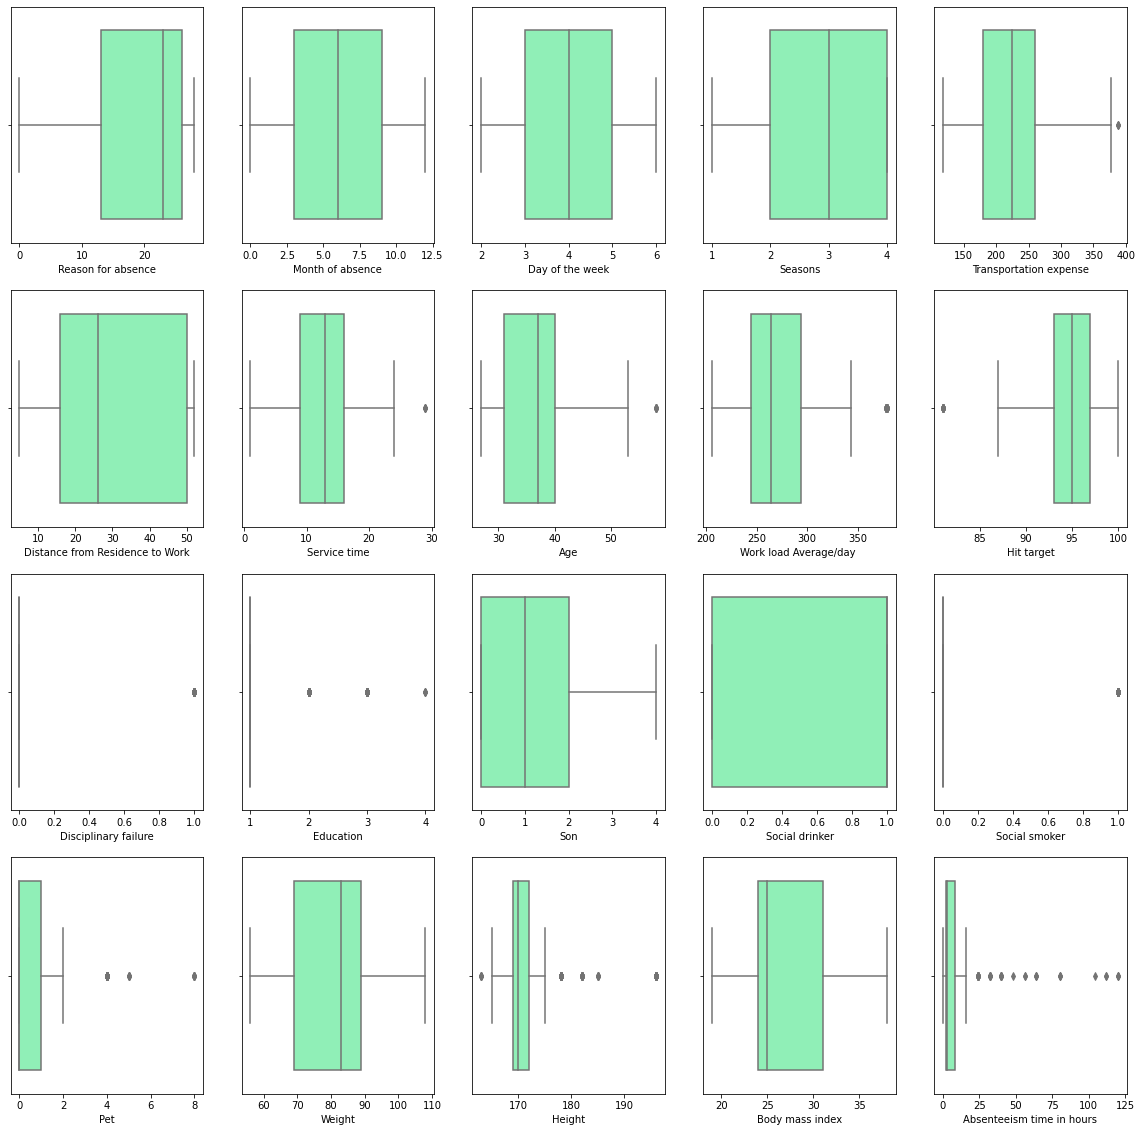

In [9]:
# Mencari Outliers by Boxplot
df_describe = df.drop(columns = ['ID'])

plt.figure(figsize =(20, 20 ))
x = 1 

for column in df_describe.columns:
    plt.subplot(4,5,x)
    sns.boxplot(x=df_describe[column], palette='rainbow')
    x+=1
plt.tight_layout
plt.show()

# Handling Missing Value

In [10]:
df.isna().sum()

ID                                 0
Reason for absence                 0
Month of absence                   0
Day of the week                    0
Seasons                            0
Transportation expense             0
Distance from Residence to Work    0
Service time                       0
Age                                0
Work load Average/day              0
Hit target                         0
Disciplinary failure               0
Education                          0
Son                                0
Social drinker                     0
Social smoker                      0
Pet                                0
Weight                             0
Height                             0
Body mass index                    0
Absenteeism time in hours          0
dtype: int64

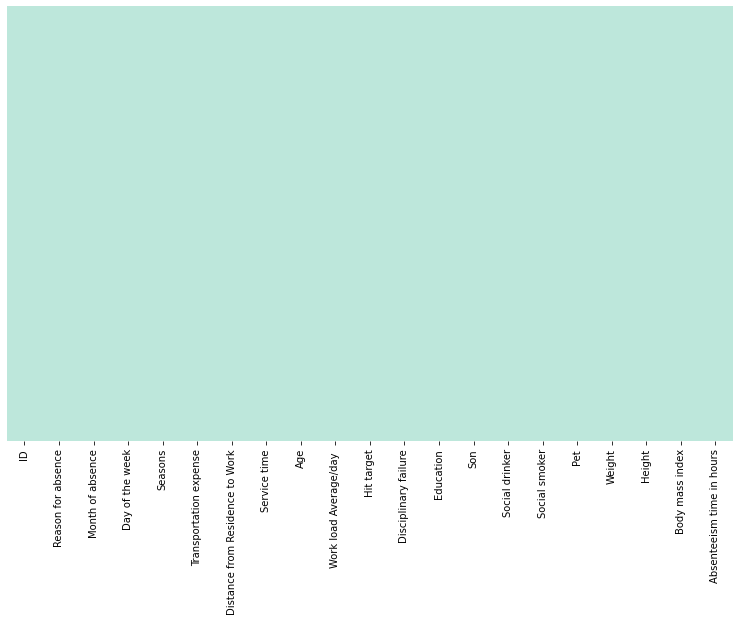

In [11]:
plt.figure(figsize=(13,8))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap='icefire')
plt.show()

# Unique Values

In [12]:
df['Reason for absence'].unique()
# unique reason

array([26,  0, 23,  7, 22, 19,  1, 11, 14, 21, 10, 13, 28, 18, 25, 24,  6,
       27, 17,  8, 12,  5,  9, 15,  4,  3,  2, 16], dtype=int64)

In [13]:
df['Month of absence'].unique()
# uniwue month of absence

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  0], dtype=int64)

In [14]:
df['Day of the week'].unique()
# unique day

array([3, 4, 5, 6, 2], dtype=int64)

In [15]:
df['Seasons'].unique()
# unique seasons

array([1, 4, 2, 3], dtype=int64)

In [16]:
df['Transportation expense'].unique()
# unique expense

array([289, 118, 179, 279, 361, 260, 155, 235, 246, 189, 248, 330, 157,
       291, 184, 225, 369, 388, 378, 228, 300, 268, 231, 233], dtype=int64)

In [17]:
df['Distance from Residence to Work'].unique()
# unique distance

array([36, 13, 51,  5, 52, 50, 12, 11, 25, 29, 16, 27, 42, 10, 20, 31, 26,
       17, 22, 15, 49, 48, 14, 35, 45], dtype=int64)

In [18]:
df['Service time'].unique()
# unique service

array([13, 18, 14,  3, 11, 16,  4,  6, 12,  7, 10,  9, 17, 29,  8,  1, 15,
       24], dtype=int64)

In [19]:
df['Age'].unique()
# unique age

array([33, 50, 38, 39, 28, 36, 34, 37, 41, 47, 29, 48, 32, 27, 43, 40, 31,
       30, 49, 58, 46, 53], dtype=int64)

In [20]:
df['Work load Average/day '].unique()
# unique load

array([239.554, 205.917, 241.476, 253.465, 306.345, 261.306, 308.593,
       302.585, 343.253, 326.452, 378.884, 377.55 , 275.312, 265.615,
       294.217, 265.017, 284.031, 236.629, 330.061, 251.818, 244.387,
       239.409, 246.074, 253.957, 230.29 , 249.797, 261.756, 284.853,
       268.519, 280.549, 313.532, 264.249, 222.196, 246.288, 237.656,
       275.089, 264.604, 271.219])

In [21]:
df['Hit target'].unique()
# unique hit target

array([ 97,  92,  93,  95,  99,  96,  94,  98,  81,  88, 100,  87,  91],
      dtype=int64)

In [22]:
df['Disciplinary failure'].unique()
# unique disciplinary

array([0, 1], dtype=int64)

In [23]:
df['Education'].unique()
# unique edu

array([1, 3, 2, 4], dtype=int64)

In [24]:
df['Son'].unique()
# unique son

array([2, 1, 0, 4, 3], dtype=int64)

In [25]:
df['Social drinker'].unique()
# unique drinker

array([1, 0], dtype=int64)

In [26]:
df['Social smoker'].unique()
# unique smoker

array([0, 1], dtype=int64)

In [27]:
df['Pet'].unique()
# unique pet

array([1, 0, 4, 2, 5, 8], dtype=int64)

In [28]:
df['Weight'].unique()
# unique weight

array([ 90,  98,  89,  68,  80,  65,  95,  88,  67,  69,  86,  84,  75,
        58,  83, 106,  73,  70,  56,  63,  76, 108,  77,  79, 100,  94],
      dtype=int64)

In [29]:
df['Height'].unique()
# unique height

array([172, 178, 170, 168, 196, 167, 165, 182, 185, 163, 169, 171, 174,
       175], dtype=int64)

In [30]:
df['Body mass index'].unique()
# unique bmi

array([30, 31, 24, 27, 23, 25, 29, 32, 22, 33, 21, 28, 38, 19, 36, 35, 34],
      dtype=int64)

In [31]:
df['Absenteeism time in hours'].unique()
# unique in hours

array([  4,   0,   2,   8,  40,   1,   7,   3,  32,   5,  16,  24,  64,
        56,  80, 120, 112, 104,  48], dtype=int64)

# Encoding

In [32]:
bin_mAbsence = [1, 12]
label = [1]
df['mAbsence_bin'] = pd.cut(df['Month of absence'], bins=bin_mAbsence, labels=label)
# bin semua month of absence 1-12 menjadi 1

In [33]:
df

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,Hit target,Disciplinary failure,Education,Son,Social drinker,Social smoker,Pet,Weight,Height,Body mass index,Absenteeism time in hours,mAbsence_bin
0,11,26,7,3,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,4,1
1,36,0,7,3,1,118,13,18,50,239.554,97,1,1,1,1,0,0,98,178,31,0,1
2,3,23,7,4,1,179,51,18,38,239.554,97,0,1,0,1,0,0,89,170,31,2,1
3,7,7,7,5,1,279,5,14,39,239.554,97,0,1,2,1,1,0,68,168,24,4,1
4,11,23,7,5,1,289,36,13,33,239.554,97,0,1,2,1,0,1,90,172,30,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,11,14,7,3,1,289,36,13,33,264.604,93,0,1,2,1,0,1,90,172,30,8,1
736,1,11,7,3,1,235,11,14,37,264.604,93,0,3,1,0,0,1,88,172,29,4,1
737,4,0,0,3,1,118,14,13,40,271.219,95,0,1,1,1,0,8,98,170,34,0,NaN
738,8,0,0,4,2,231,35,14,39,271.219,95,0,1,2,1,0,2,100,170,35,0,NaN


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   ID                               740 non-null    int64   
 1   Reason for absence               740 non-null    int64   
 2   Month of absence                 740 non-null    int64   
 3   Day of the week                  740 non-null    int64   
 4   Seasons                          740 non-null    int64   
 5   Transportation expense           740 non-null    int64   
 6   Distance from Residence to Work  740 non-null    int64   
 7   Service time                     740 non-null    int64   
 8   Age                              740 non-null    int64   
 9   Work load Average/day            740 non-null    float64 
 10  Hit target                       740 non-null    int64   
 11  Disciplinary failure             740 non-null    int64   
 12  Educatio

In [35]:
df = df.astype({"mAbsence_bin": object})
# ganti absence_bin jadi object

In [36]:
df['mAbsence_bin'] = df['mAbsence_bin'].fillna('0')
# isi fillna menjadi 0

In [37]:
df = df.astype({"mAbsence_bin": int})
# ganti absence_bin jadi int

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               740 non-null    int64  
 1   Reason for absence               740 non-null    int64  
 2   Month of absence                 740 non-null    int64  
 3   Day of the week                  740 non-null    int64  
 4   Seasons                          740 non-null    int64  
 5   Transportation expense           740 non-null    int64  
 6   Distance from Residence to Work  740 non-null    int64  
 7   Service time                     740 non-null    int64  
 8   Age                              740 non-null    int64  
 9   Work load Average/day            740 non-null    float64
 10  Hit target                       740 non-null    int64  
 11  Disciplinary failure             740 non-null    int64  
 12  Education             

# Percentage

In [39]:
pd.crosstab(index=df['mAbsence_bin'], columns='count', normalize=True)
# percentage

col_0,count
mAbsence_bin,
0,0.071622
1,0.928378


# Feature Selection

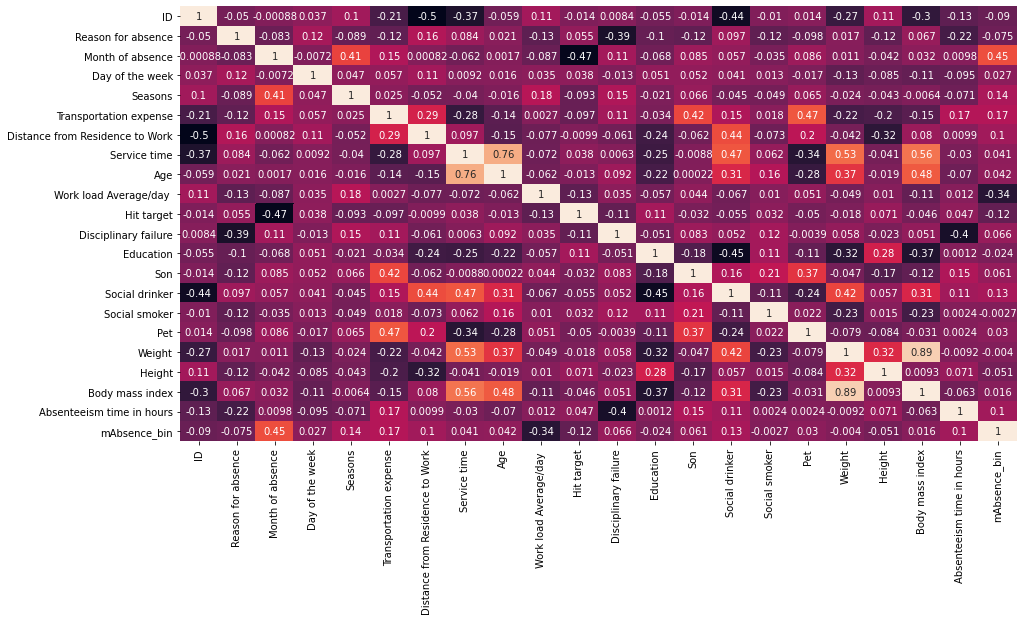

In [40]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr('spearman'), annot=True, cbar=False)
plt.show()

In [41]:
def corr_ratio(categories, measurement):
    fcat, _ = pd.factorize(categories) # factorize: ubah jd angka
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range (0, cat_num):
        cat_measure = measurement[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measure)
        y_avg_array[i] = np.average(cat_measure)
    y_total_avg = np.sum(np.multiply(y_avg_array, n_array)) / np.sum(n_array)
    numerator = np.sum(np.multiply(n_array, np.power(np.subtract(y_avg_array, y_total_avg), 2)))
    denominator = np.sum(np.power(np.subtract(measurement, y_total_avg), 2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator / denominator)
    return eta

In [42]:
correlation_ratio(df['Transportation expense'], df['mAbsence_bin'])

0.24483682484602037

In [43]:
correlation_ratio(df['Distance from Residence to Work'], df['mAbsence_bin'])

0.32154365164664667

In [44]:
correlation_ratio(df['Service time'], df['mAbsence_bin'])

0.2674823282619244

In [45]:
correlation_ratio(df['Age'], df['mAbsence_bin'])

0.2701434169394805

In [46]:
correlation_ratio(df['Work load Average/day '], df['mAbsence_bin'])

1.0

In [47]:
correlation_ratio(df['Hit target'], df['mAbsence_bin'])

0.6363388110708604

In [48]:
correlation_ratio(df['Disciplinary failure'], df['mAbsence_bin'])

0.06639578988875075

In [49]:
correlation_ratio(df['Education'], df['mAbsence_bin'])

0.034687573056945475

In [50]:
correlation_ratio(df['Son'], df['mAbsence_bin'])

0.09790991742934478

In [51]:
correlation_ratio(df['Social drinker'], df['mAbsence_bin'])

0.12779727134365307

In [52]:
correlation_ratio(df['Social smoker'], df['mAbsence_bin'])

0.002668399401657212

In [53]:
correlation_ratio(df['Pet'], df['mAbsence_bin'])

0.08376789635600494

In [54]:
correlation_ratio(df['Weight'], df['mAbsence_bin'])

0.2947712957476044

In [55]:
correlation_ratio(df['Height'], df['mAbsence_bin'])

0.16423123623708585

In [56]:
correlation_ratio(df['Body mass index'], df['mAbsence_bin'])

0.2774084523917207

## Univariate

In [57]:
df.columns

Index(['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
       'Seasons', 'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours', 'mAbsence_bin'],
      dtype='object')

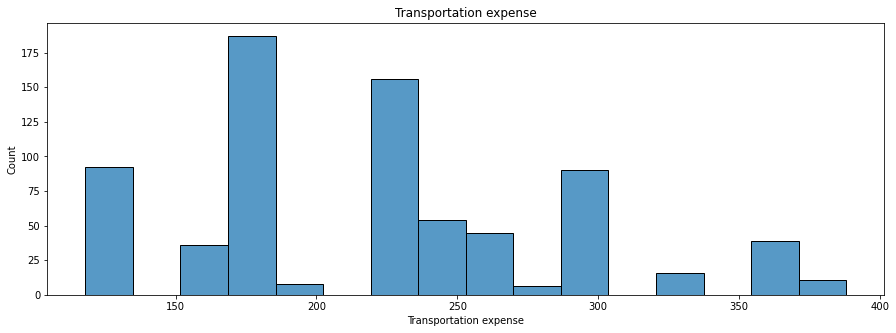

In [58]:
plt.figure(figsize = (15,5))
sns.histplot(data=df, x="Transportation expense")
plt.title("Transportation expense")
plt.show()

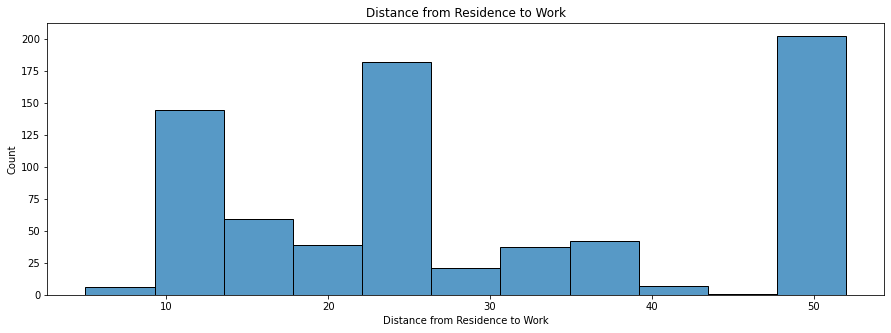

In [59]:
plt.figure(figsize = (15,5))
sns.histplot(data=df, x="Distance from Residence to Work")
plt.title("Distance from Residence to Work")
plt.show()

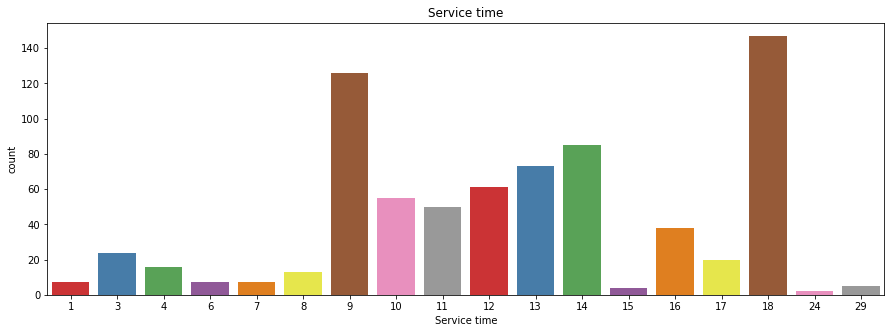

In [60]:
plt.figure(figsize = (15,5))
sns.countplot(df['Service time'], palette='Set1')
plt.title("Service time")
plt.show()

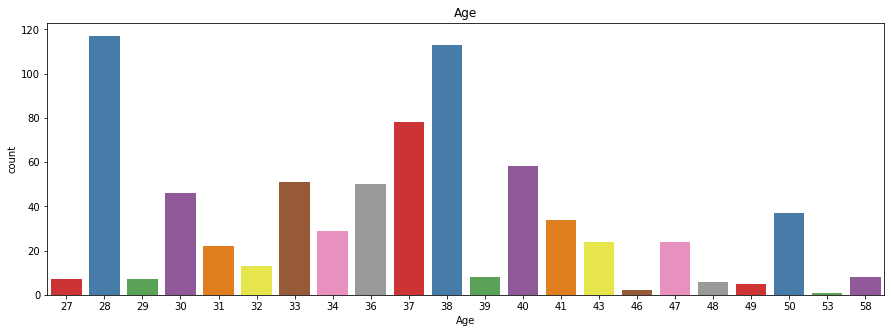

In [61]:
plt.figure(figsize = (15,5))
sns.countplot(df['Age'], palette='Set1')
plt.title("Age")
plt.show()

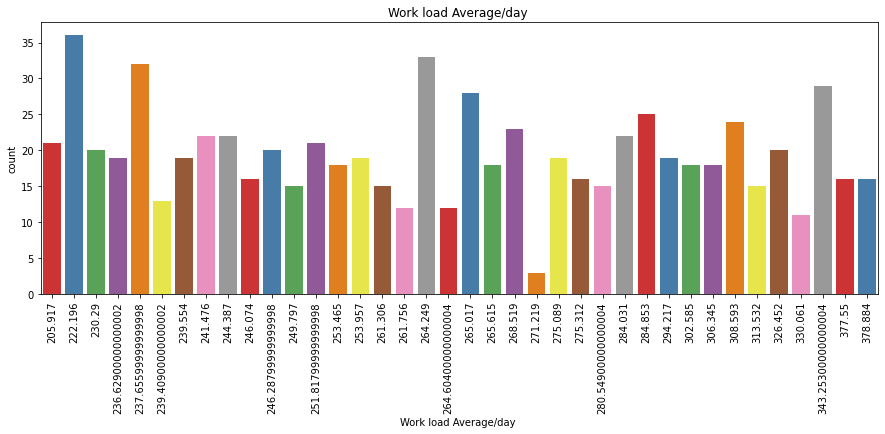

In [62]:
plt.figure(figsize = (15,5))
sns.countplot(df['Work load Average/day '], palette='Set1')
plt.xticks(rotation=90)
plt.title("Work load Average/day ")
plt.show()

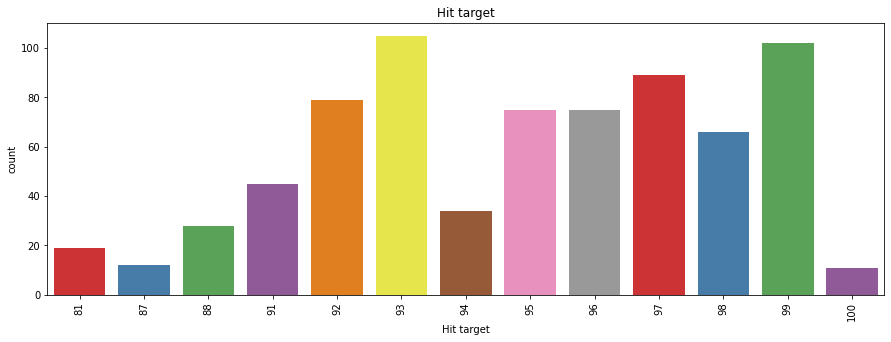

In [63]:
plt.figure(figsize = (15,5))
sns.countplot(df['Hit target'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Hit target")
plt.show()

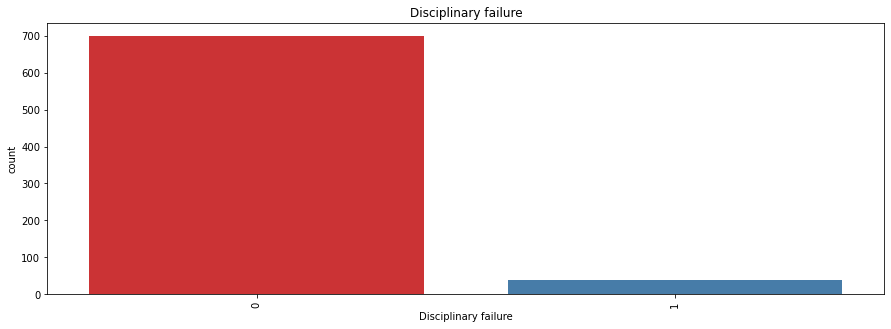

In [64]:
plt.figure(figsize = (15,5))
sns.countplot(df['Disciplinary failure'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Disciplinary failure")
plt.show()

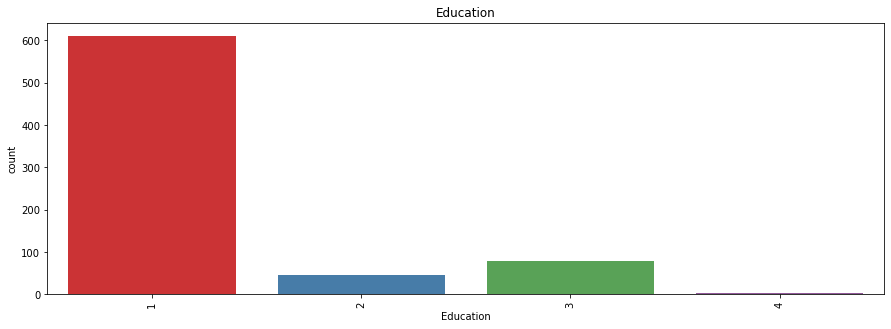

In [65]:
plt.figure(figsize = (15,5))
sns.countplot(df['Education'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Education")
plt.show()

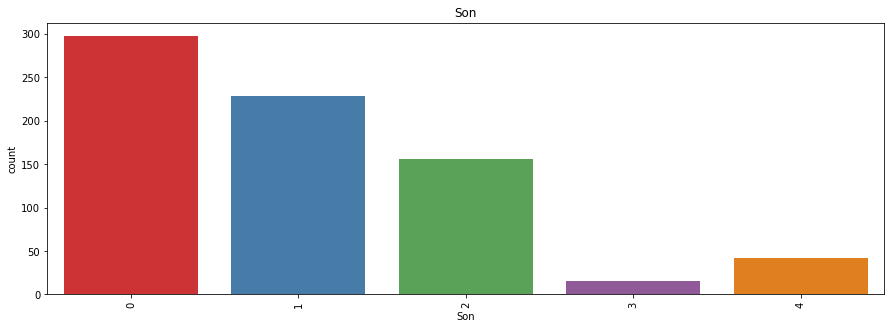

In [66]:
plt.figure(figsize = (15,5))
sns.countplot(df['Son'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Son")
plt.show()

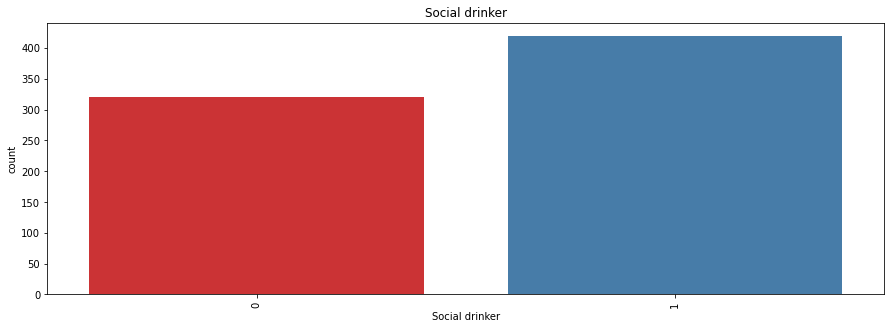

In [67]:
plt.figure(figsize = (15,5))
sns.countplot(df['Social drinker'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Social drinker")
plt.show()

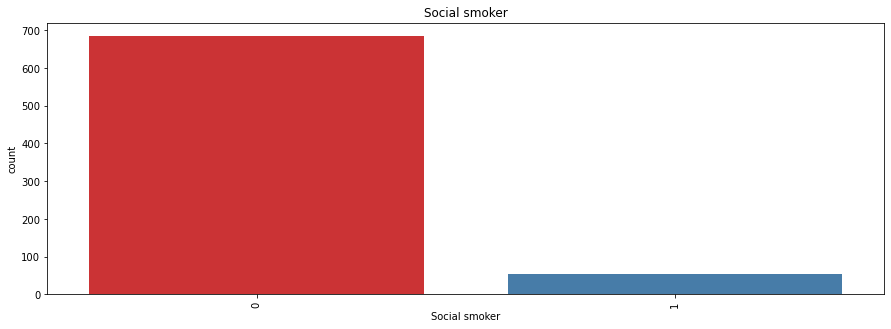

In [68]:
plt.figure(figsize = (15,5))
sns.countplot(df['Social smoker'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Social smoker")
plt.show()

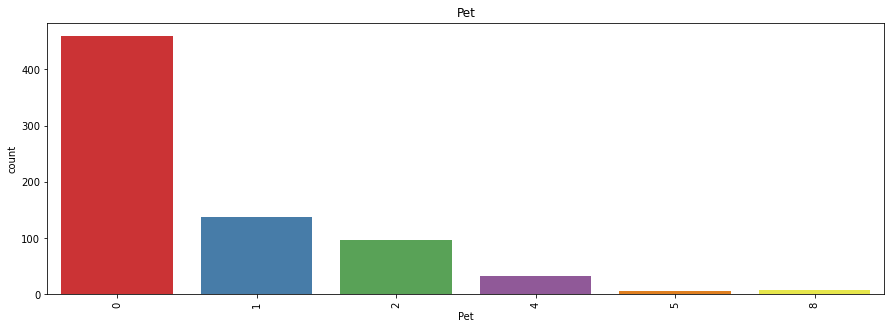

In [69]:
plt.figure(figsize = (15,5))
sns.countplot(df['Pet'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Pet")
plt.show()

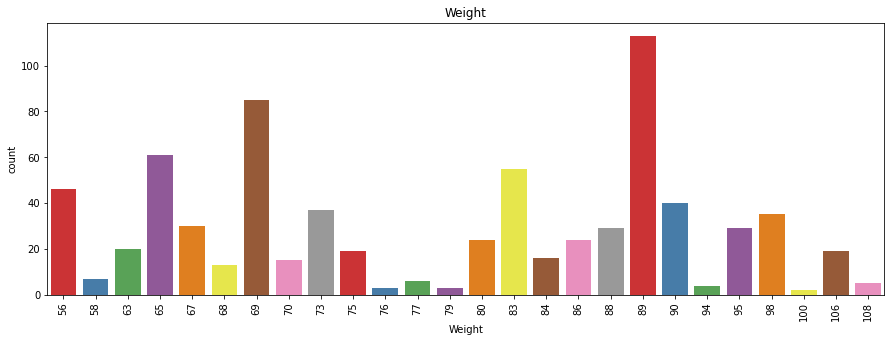

In [70]:
plt.figure(figsize = (15,5))
sns.countplot(df['Weight'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Weight")
plt.show()

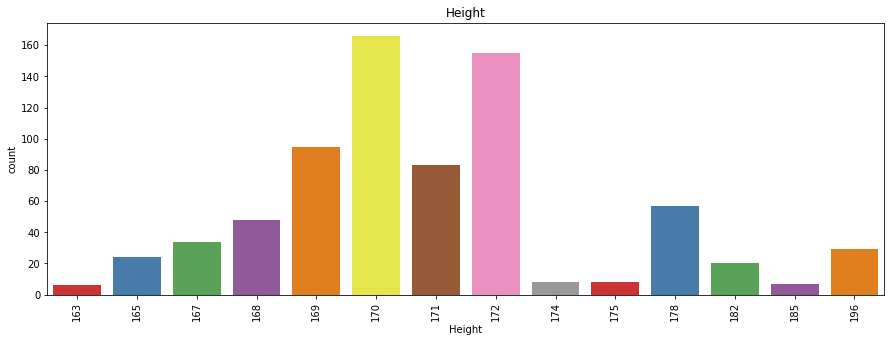

In [71]:
plt.figure(figsize = (15,5))
sns.countplot(df['Height'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Height")
plt.show()

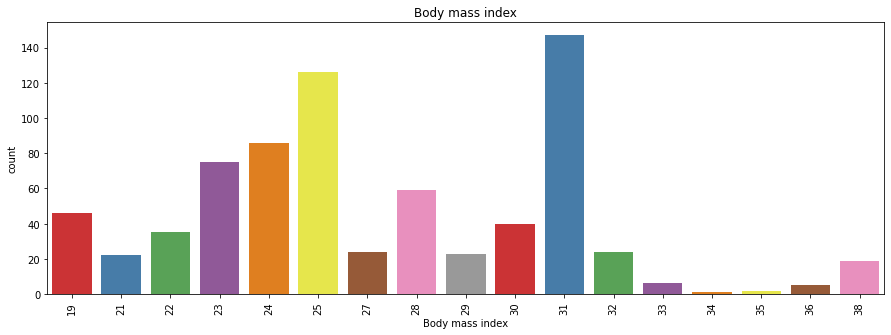

In [72]:
plt.figure(figsize = (15,5))
sns.countplot(df['Body mass index'], palette='Set1')
plt.xticks(rotation=90)
plt.title("Body mass index")
plt.show()

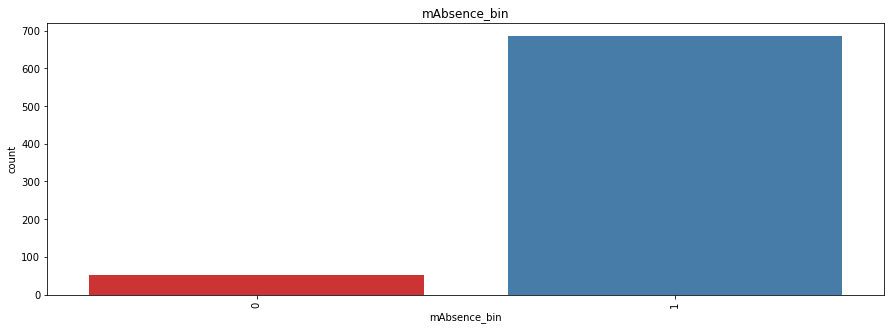

In [73]:
plt.figure(figsize = (15,5))
sns.countplot(df['mAbsence_bin'], palette='Set1')
plt.xticks(rotation=90)
plt.title("mAbsence_bin")
plt.show()

## Multivariate

In [74]:
df.columns

Index(['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
       'Seasons', 'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours', 'mAbsence_bin'],
      dtype='object')

In [75]:
a= (pd.crosstab(index=df['Son'], columns=df['mAbsence_bin']))
top_son= a.sort_values(by=[1],ascending= False).head(10)
top_son.reset_index(inplace=True)
top_son
# Insight tidak punya anak lebih banyak absen

mAbsence_bin,Son,0,1
0,0,27,271
1,1,13,216
2,2,13,143
3,4,0,42
4,3,0,15


In [76]:
a= (pd.crosstab(index=df['Age'], columns=df['mAbsence_bin']))
top_age= a.sort_values(by=[1],ascending= False).head(10)
top_age.reset_index(inplace=True)
top_age
# Insight umur muda lebih banyak absen

mAbsence_bin,Age,0,1
0,28,7,110
1,38,5,108
2,37,14,64
3,40,6,52
4,36,0,50
5,33,4,47
6,30,6,40
7,50,1,36
8,41,0,34
9,34,4,25


In [77]:
a= (pd.crosstab(index=df['Disciplinary failure'], columns=df['mAbsence_bin']))
top_dis= a.sort_values(by=[1],ascending= False).head(10)
top_dis.reset_index(inplace=True)
top_dis

mAbsence_bin,Disciplinary failure,0,1
0,0,53,647
1,1,0,40


In [78]:
a= (pd.crosstab(index=df['Social drinker'], columns=df['mAbsence_bin']))
top_dri= a.sort_values(by=[1],ascending= False).head(10)
top_dri.reset_index(inplace=True)
top_dri

mAbsence_bin,Social drinker,0,1
0,1,18,402
1,0,35,285


In [79]:
a= (pd.crosstab(index=df['Social smoker'], columns=df['mAbsence_bin']))
top_smo= a.sort_values(by=[1],ascending= False).head(10)
top_smo.reset_index(inplace=True)
top_smo

mAbsence_bin,Social smoker,0,1
0,0,49,637
1,1,4,50


In [80]:
a= (pd.crosstab(index=df['Transportation expense'], columns=df['mAbsence_bin']))
top_trans= a.sort_values(by=[1],ascending= False).head(10)
top_trans.reset_index(inplace=True)
top_trans

mAbsence_bin,Transportation expense,0,1
0,179,16,164
1,118,15,77
2,225,7,74
3,235,2,56
4,260,0,42
5,289,5,40
6,291,1,39
7,246,0,30
8,155,4,25
9,361,0,24


In [81]:
a= (pd.crosstab(index=df['Distance from Residence to Work'], columns=df['mAbsence_bin']))
top_dist= a.sort_values(by=[1],ascending= False).head(10)
top_dist.reset_index(inplace=True)
top_dist

mAbsence_bin,Distance from Residence to Work,0,1
0,26,13,115
1,51,5,115
2,25,0,54
3,50,0,45
4,10,13,42
5,36,4,36
6,31,1,36
7,13,1,33
8,16,0,26
9,11,1,25


In [82]:
a= (pd.crosstab(index=df['Service time'], columns=df['mAbsence_bin']))
top_ser= a.sort_values(by=[1],ascending= False).head(10)
top_ser.reset_index(inplace=True)
top_ser

mAbsence_bin,Service time,0,1
0,18,6,141
1,9,13,113
2,14,7,78
3,13,6,67
4,12,1,60
5,11,0,50
6,10,13,42
7,16,0,38
8,3,0,24
9,4,0,16


In [83]:
a= (pd.crosstab(index=df['Work load Average/day '], columns=df['mAbsence_bin']))
top_wl= a.sort_values(by=[1],ascending= False).head(10)
top_wl.reset_index(inplace=True)
top_wl

mAbsence_bin,Work load Average/day,0,1
0,222.196,0,36
1,264.249,0,33
2,237.656,0,32
3,343.253,0,29
4,265.017,0,28
5,284.853,0,25
6,268.519,0,23
7,284.031,0,22
8,241.476,0,22
9,244.387,0,22


In [84]:
a= (pd.crosstab(index=df['Education'], columns=df['mAbsence_bin']))
top_edu= a.sort_values(by=[1],ascending= False).head(10)
top_edu.reset_index(inplace=True)
top_edu
# Insight Edu rendah lebih banyak absen

mAbsence_bin,Education,0,1
0,1,42,569
1,3,7,72
2,2,4,42
3,4,0,4


In [85]:
a= (pd.crosstab(index=df['Pet'], columns=df['mAbsence_bin']))
top_pet= a.sort_values(by=[1],ascending= False).head(10)
top_pet.reset_index(inplace=True)
top_pet
# Tidak punya pet lebih banyak absen

mAbsence_bin,Pet,0,1
0,0,36,424
1,1,7,131
2,2,9,87
3,4,0,32
4,8,1,7
5,5,0,6


In [86]:
a= (pd.crosstab(index=df['Weight'], columns=df['mAbsence_bin']))
top_wei= a.sort_values(by=[1],ascending= False).head(10)
top_wei.reset_index(inplace=True)
top_wei
# Insight banyak yg berat badan tinggi yg absen

mAbsence_bin,Weight,0,1
0,89,5,108
1,69,7,78
2,65,0,61
3,83,13,42
4,56,6,40
5,90,4,36
6,73,1,36
7,98,2,33
8,67,0,30
9,88,1,28


In [87]:
a= (pd.crosstab(index=df['Height'], columns=df['mAbsence_bin']))
top_hei= a.sort_values(by=[1],ascending= False).head(10)
top_hei.reset_index(inplace=True)
top_hei

mAbsence_bin,Height,0,1
0,170,11,155
1,172,19,136
2,169,7,88
3,171,7,76
4,178,1,56
5,168,0,48
6,167,3,31
7,196,4,25
8,165,0,24
9,182,0,20


In [88]:
a= (pd.crosstab(index=df['Body mass index'], columns=df['mAbsence_bin']))
top_bmi= a.sort_values(by=[1],ascending= False).head(10)
top_bmi.reset_index(inplace=True)
top_bmi

mAbsence_bin,Body mass index,0,1
0,31,6,141
1,25,6,120
2,24,7,79
3,23,0,75
4,28,13,46
5,19,6,40
6,30,4,36
7,22,4,31
8,27,0,24
9,32,0,24


# Evaluation Matrix

In [89]:
# Eva Matrix
def Eva_Matrix(Model, X, y_true):
    y_pred = Model.predict(X)
    Acc = accuracy_score(y_true, y_pred)
    Rec = recall_score(y_true, y_pred)
    Prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return Acc, Rec, Prec, f1

In [90]:
# Evaluation Matrix Classification
def Eva_Matrix1(Model, X_train, y_train, X_test, y_test, Name):
    y_pred_train = Model.predict(X_train)
    acc_train = accuracy_score(y_train, y_pred_train)
    rec_train = recall_score(y_train, y_pred_train)
    prec_train = precision_score(y_train, y_pred_train)
    f1_train = f1_score(y_train, y_pred_train)
    y_pred_test = Model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred_test)
    rec_test = recall_score(y_test, y_pred_test)
    prec_test = precision_score(y_test, y_pred_test)
    f1_test = f1_score(y_train, y_pred_train)
    data = {
        f"Training {Name}" : [acc_train, rec_train, prec_train, f1_train],
        f"Test {Name}" : [acc_test, rec_test, prec_test, f1_test]
    }
    df = pd.DataFrame(data=data, index=['Accuracy', 'Recall', 'Precision', 'F1'])
    return df

# Pipeline

In [91]:
# num_columns = ['Transportation expense', 'Transportation expense', 'Service time', 'Age', 'Work load Average/day ', 'Hit target', 'Weight', 'Height', 'Body mass index', 'Absenteeism time in hours']

# cat_columns = ['Reason for absence', 'Month of absence', 'Day of the week', 'Seasons', 'Disciplinary failure', 'Education', 'Son', 'Social drinker', 'Social drinker', 'Pet']

# numeric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', RobustScaler()),
#     #('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     #('power', PowerTransformer(method='yeo-johnson'))
# ])

# categoric_pipeline = Pipeline([
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('encoder', OneHotEncoder())
# ])

# preprocessor = ColumnTransformer([
#     ('numeric', numeric_pipeline, num_columns),
#     ('categoric', categoric_pipeline, cat_columns)
# ])

# pipeSVM = Pipeline([
#     ("prep", preprocessor),
#     ("algo", SVC(max_iter=400, probability=True))
# ])

# pipeLR = Pipeline([
#     ("prep", preprocessor),
#     ("algo", LogisticRegression())
# ])

# pipeKNN = Pipeline([
#     ("prep", preprocessor),
#     ("algo", KNeighborsClassifier())
# ])
               
# pipeDT = Pipeline([
#     ("prep", preprocessor),
#     ("algo", DecisionTreeClassifier(class_weight = {0: 0.4, 1: 0.6}))
# ])
            
# pipeRF = Pipeline([
#     ("prep", preprocessor),
#     ("algo", RandomForestClassifier())
# ])

# Base Model

In [92]:
df.columns

Index(['ID', 'Reason for absence', 'Month of absence', 'Day of the week',
       'Seasons', 'Transportation expense', 'Distance from Residence to Work',
       'Service time', 'Age', 'Work load Average/day ', 'Hit target',
       'Disciplinary failure', 'Education', 'Son', 'Social drinker',
       'Social smoker', 'Pet', 'Weight', 'Height', 'Body mass index',
       'Absenteeism time in hours', 'mAbsence_bin'],
      dtype='object')

## Feature Selection:
- 'Seasons' - musim
- 'Transportation expense' - biaya transport
- 'Distance from Residence to Work' - jarak rumah ke kantor
- 'Service time' - waktu kerja
- 'Age' - umur
- 'Disciplinary failure' - mendapatkan teguran
- 'Education' - tingkat edukasi
- 'Son' - jumlah anak
- 'Pet' - jumlah pet
- 'Weight' - berat badan
- 'Height' - tinggi badan
- 'mAbsence_bin' - absen

In [93]:
df_ML = df[['Seasons', 'Transportation expense', 'Distance from Residence to Work', 'Service time', 'Age', 'Disciplinary failure', 'Education', 'Son', 'Pet', 'Weight', 'Height', 'mAbsence_bin']]

In [94]:
df_ML

,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Disciplinary failure,Education,Son,Pet,Weight,Height,mAbsence_bin
0,1,289,36,13,33,0,1,2,1,90,172,1
1,1,118,13,18,50,1,1,1,0,98,178,1
2,1,179,51,18,38,0,1,0,0,89,170,1
3,1,279,5,14,39,0,1,2,0,68,168,1
4,1,289,36,13,33,0,1,2,1,90,172,1
...,...,...,...,...,...,...,...,...,...,...,...,...
735,1,289,36,13,33,0,1,2,1,90,172,1
736,1,235,11,14,37,0,3,1,1,88,172,1
737,1,118,14,13,40,0,1,1,8,98,170,0
738,2,231,35,14,39,0,1,2,2,100,170,0


In [95]:
pd.crosstab(index=df_ML['mAbsence_bin'], columns='count', normalize=True)

col_0,count
mAbsence_bin,
0,0.071622
1,0.928378


In [96]:
X = df_ML.drop(columns='mAbsence_bin')
y = df_ML['mAbsence_bin']

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.20, random_state = 42)

In [98]:
df_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   Seasons                          740 non-null    int64
 1   Transportation expense           740 non-null    int64
 2   Distance from Residence to Work  740 non-null    int64
 3   Service time                     740 non-null    int64
 4   Age                              740 non-null    int64
 5   Disciplinary failure             740 non-null    int64
 6   Education                        740 non-null    int64
 7   Son                              740 non-null    int64
 8   Pet                              740 non-null    int64
 9   Weight                           740 non-null    int64
 10  Height                           740 non-null    int64
 11  mAbsence_bin                     740 non-null    int32
dtypes: int32(1), int64(11)
memory usage: 66.6 KB


In [99]:
num_col = ['Age', 'Weight', 'Height']

cat_col = ['Seasons', 'Disciplinary failure', 'Education', 'Son', 'Pet']

## SVM

In [100]:
Model_SVM = SVC(max_iter=400)

In [101]:
Model_SVM.fit(X_train, y_train)

SVC(max_iter=400)

In [102]:
# Evaluation Base Model SVM
SVM_Acc_train, SVM_Rec_train, SVM_Prec_train, SVM_f1_train = Eva_Matrix(Model_SVM, X_train, y_train)
SVM_Acc_test, SVM_Rec_test, SVM_Prec_test, SVM_f1_test = Eva_Matrix(Model_SVM, X_test, y_test)
data_SVM = {
    "SVM Train" : [SVM_Acc_train, SVM_Rec_train, SVM_Prec_train, SVM_f1_train],
    "SVM Test" : [SVM_Acc_test, SVM_Rec_test, SVM_Prec_test, SVM_f1_test]
}
pd.DataFrame(data=data_SVM, index=['Accuracy', 'Recall', 'Precision', 'F1'])

,SVM Train,SVM Test
Accuracy,0.929054,0.925676
Recall,1.000000,1.000000
Precision,0.929054,0.925676
F1,0.963222,0.961404


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.93      1.00      0.96       137

    accuracy                           0.93       148
   macro avg       0.46      0.50      0.48       148
weighted avg       0.86      0.93      0.89       148



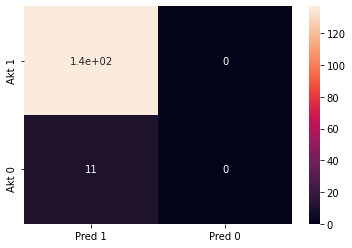

In [103]:
from sklearn.metrics import confusion_matrix, classification_report
y_SVM_test = Model_SVM.predict(X_test)
print(classification_report(y_test, y_SVM_test))
cm_SVM_test = confusion_matrix(y_test, y_SVM_test, labels = [1,0])
df_SVM_test = pd.DataFrame(data=cm_SVM_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_SVM_test, annot=True)
plt.show()

## LogReg

In [104]:
Model_LR = LogisticRegression()

In [105]:
Model_LR.fit(X_train, y_train)

LogisticRegression()

In [106]:
# Evaluation Base Model Logistic Regression
Log_Acc_train, Log_Rec_train, Log_Prec_train, Log_f1_train = Eva_Matrix(Model_LR, X_train, y_train)
Log_Acc_test, Log_Rec_test, Log_Prec_test, Log_f1_test = Eva_Matrix(Model_LR, X_test, y_test)
data_log = {
    "Log Train" : [Log_Acc_train, Log_Rec_train, Log_Prec_train, Log_f1_train],
    "Log Test" : [Log_Acc_test, Log_Rec_test, Log_Prec_test, Log_f1_test]
}
pd.DataFrame(data=data_log, index=['Accuracy', 'Recall', 'Precision', 'F1'])

,Log Train,Log Test
Accuracy,0.930743,0.925676
Recall,1.000000,1.000000
Precision,0.930626,0.925676
F1,0.964067,0.961404


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.93      1.00      0.96       137

    accuracy                           0.93       148
   macro avg       0.46      0.50      0.48       148
weighted avg       0.86      0.93      0.89       148



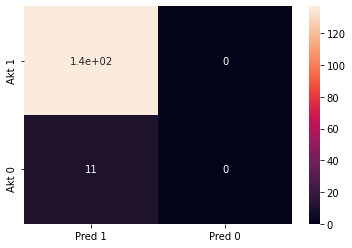

In [107]:
from sklearn.metrics import confusion_matrix, classification_report
y_LR_test = Model_LR.predict(X_test)
print(classification_report(y_test, y_LR_test))
cm_LR_test = confusion_matrix(y_test, y_LR_test, labels = [1,0])
df_LR_test = pd.DataFrame(data=cm_LR_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_LR_test, annot=True)
plt.show()

## KNeighborsClassifier

In [108]:
Model_KNN = KNeighborsClassifier()

In [109]:
Model_KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [110]:
# Evaluation Base Model KNeighborsClassifier
KNN_Acc_train, KNN_Rec_train, KNN_Prec_train, KNN_f1_train = Eva_Matrix(Model_KNN, X_train, y_train)
KNN_Acc_test, KNN_Rec_test, KNN_Prec_test, KNN_f1_test = Eva_Matrix(Model_KNN, X_test, y_test)
data_KNN = {
    "KNN Train" : [KNN_Acc_train, KNN_Rec_train, KNN_Prec_train, KNN_f1_train],
    "KNN Test" : [KNN_Acc_test, KNN_Rec_test, KNN_Prec_test, KNN_f1_test]
}
pd.DataFrame(data=data_KNN, index=['Accuracy', 'Recall', 'Precision', 'F1'])

,KNN Train,KNN Test
Accuracy,0.940878,0.952703
Recall,0.996364,1.000000
Precision,0.943201,0.951389
F1,0.969054,0.975089


              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.95      1.00      0.98       137

    accuracy                           0.95       148
   macro avg       0.98      0.68      0.75       148
weighted avg       0.96      0.95      0.94       148



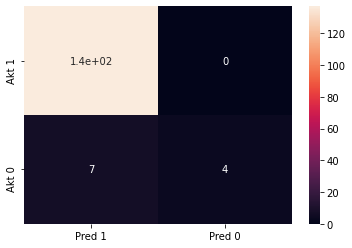

In [111]:
from sklearn.metrics import confusion_matrix, classification_report
y_KNN_test = Model_KNN.predict(X_test)
print(classification_report(y_test, y_KNN_test))
cm_KNN_test = confusion_matrix(y_test, y_KNN_test, labels = [1,0])
df_KNN_test = pd.DataFrame(data=cm_KNN_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_KNN_test, annot=True)
plt.show()

## Decision Tree Classifier

In [112]:
Model_DT = DecisionTreeClassifier()

In [113]:
Model_DT.fit(X_train, y_train)

DecisionTreeClassifier()

In [114]:
DT_Acc_train, DT_Rec_train, DT_Prec_train, DT_f1_train = Eva_Matrix(Model_DT, X_train, y_train)
DT_Acc_test, DT_Rec_test, DT_Prec_test, DT_f1_test = Eva_Matrix(Model_DT, X_test, y_test)
data_DT ={
    'DT Train' : [DT_Acc_train, DT_Rec_train, DT_Prec_train, DT_f1_train],
    'DT Test': [DT_Acc_test, DT_Rec_test, DT_Prec_test, DT_f1_test] 
}
pd.DataFrame(data=data_DT, index=['Accuracy', 'Recall','Precision','F1'])

,DT Train,DT Test
Accuracy,0.945946,0.945946
Recall,0.983636,0.992701
Precision,0.959220,0.951049
F1,0.971275,0.971429


              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.95      0.99      0.97       137

    accuracy                           0.95       148
   macro avg       0.88      0.68      0.74       148
weighted avg       0.94      0.95      0.94       148



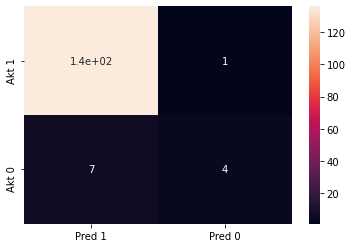

In [115]:
from sklearn.metrics import confusion_matrix, classification_report
y_DT_test = Model_DT.predict(X_test)
print(classification_report(y_test, y_DT_test))
cm_DT_test = confusion_matrix(y_test, y_DT_test, labels = [1,0])
df_DT_test = pd.DataFrame(data=cm_DT_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_DT_test, annot=True)
plt.show()

## Random Forest

In [116]:
Model_RF = RandomForestClassifier()

In [117]:
Model_RF.fit(X_train, y_train)

RandomForestClassifier()

In [118]:
RF_Acc_train, RF_Rec_train, RF_Prec_train, RF_f1_train = Eva_Matrix(Model_RF, X_train, y_train)
RF_Acc_test, RF_Rec_test, RF_Prec_test, RF_f1_test = Eva_Matrix(Model_RF, X_test, y_test)
data_RF ={
    'RF Train' : [RF_Acc_train, RF_Rec_train, RF_Prec_train, RF_f1_train],
    'RF Test': [RF_Acc_test, RF_Rec_test, RF_Prec_test, RF_f1_test] 
}
pd.DataFrame(data=data_RF, index=['Accuracy', 'Recall','Precision','F1'])

,RF Train,RF Test
Accuracy,0.945946,0.952703
Recall,0.996364,1.000000
Precision,0.948097,0.951389
F1,0.971631,0.975089


              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.95      1.00      0.98       137

    accuracy                           0.95       148
   macro avg       0.98      0.68      0.75       148
weighted avg       0.96      0.95      0.94       148



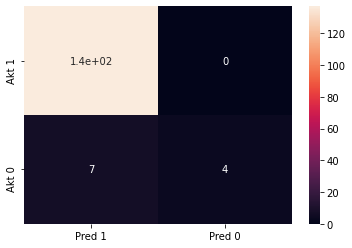

In [119]:
from sklearn.metrics import confusion_matrix, classification_report
y_RF_test = Model_RF.predict(X_test)
print(classification_report(y_test, y_RF_test))
cm_RF_test = confusion_matrix(y_test, y_RF_test, labels = [1,0])
df_RF_test = pd.DataFrame(data=cm_RF_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_RF_test, annot=True)
plt.show()

# Hyper Parameter Tuning

## Decision Tree

In [120]:
param_DT = {
    "max_depth" : [None, 2, 5],
    "min_samples_split" : np.arange(0, 20, 2),
    "min_samples_leaf" : np.arange(0, 20, 4),
    "max_features" : [None, np.arange(0, 0.6, 0.1)],
    "class_weight" : [{0 : x, 1 : 1 - x} for x in [.4, .45, .5]]
}

In [121]:
skf = StratifiedKFold(n_splits=3)

In [122]:
DT_Tuned = GridSearchCV(Model_DT, param_DT, cv = skf, n_jobs = -1, verbose = 1, scoring='recall')

In [123]:
DT_Tuned.fit(X_train, y_train)

Fitting 3 folds for each of 900 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 2293 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed:    4.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [{0: 0.4, 1: 0.6}, {0: 0.45, 1: 0.55},
                                          {0: 0.5, 1: 0.5}],
                         'max_depth': [None, 2, 5],
                         'max_features': [None,
                                          array([0. , 0.1, 0.2, 0.3, 0.4, 0.5])],
                         'min_samples_leaf': array([ 0,  4,  8, 12, 16]),
                         'min_samples_split': array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18])},
             scoring='recall', verbose=1)

In [124]:
DT_Tuned.best_params_

{'class_weight': {0: 0.4, 1: 0.6},
 'max_depth': 2,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [125]:
DT_Tuned = DecisionTreeClassifier(class_weight = {0: 0.365, 1: 0.635}, max_depth = None, max_features = None, min_samples_leaf = 3, min_samples_split = 23)

In [126]:
DT_Tuned.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={0: 0.365, 1: 0.635}, min_samples_leaf=3,
                       min_samples_split=23)

In [127]:
y_predDT_tuned = DT_Tuned.predict(X_test)

In [128]:
df_DT_Tuned = Eva_Matrix1(DT_Tuned, X_train, y_train, X_test, y_test, "Model (DT Tuned)")
df_DT_Tuned

,Training Model (DT Tuned),Test Model (DT Tuned)
Accuracy,0.942568,0.952703
Recall,0.996364,1.000000
Precision,0.944828,0.951389
F1,0.969912,0.969912


              precision    recall  f1-score   support

           0       1.00      0.36      0.53        11
           1       0.95      1.00      0.98       137

    accuracy                           0.95       148
   macro avg       0.98      0.68      0.75       148
weighted avg       0.96      0.95      0.94       148



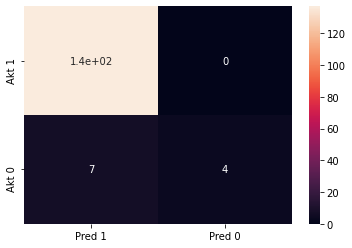

In [129]:
from sklearn.metrics import confusion_matrix, classification_report
y_DT_tuned_test = DT_Tuned.predict(X_test)
print(classification_report(y_test, y_DT_tuned_test))
cm_DT_tuned_test = confusion_matrix(y_test, y_DT_tuned_test, labels = [1,0])
df_DT_tuned_test = pd.DataFrame(data=cm_DT_tuned_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_DT_tuned_test, annot=True)
plt.show()

## SMOTE DT

In [130]:
sm = SMOTE(random_state=42)

In [131]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [132]:
df_SMOTE = pd.concat([X_train_sm, y_train_sm], axis=1)
df_SMOTE['mAbsence_bin'].value_counts()

1    550
0    550
Name: mAbsence_bin, dtype: int64

In [133]:
DT_Tuned.fit(X_train_sm, y_train_sm)

DecisionTreeClassifier(class_weight={0: 0.365, 1: 0.635}, min_samples_leaf=3,
                       min_samples_split=23)

In [134]:
df_DT_Tuned_SM = Eva_Matrix1(DT_Tuned, X_train_sm, y_train_sm, X_test, y_test, "Model (DT Tuned SM)")
df_DT_Tuned_SM

,Training Model (DT Tuned SM),Test Model (DT Tuned SM)
Accuracy,0.910909,0.912162
Recall,0.947273,0.927007
Precision,0.883051,0.976923
F1,0.914035,0.914035


              precision    recall  f1-score   support

           0       0.44      0.73      0.55        11
           1       0.98      0.93      0.95       137

    accuracy                           0.91       148
   macro avg       0.71      0.83      0.75       148
weighted avg       0.94      0.91      0.92       148



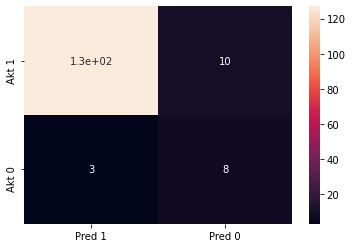

In [135]:
from sklearn.metrics import confusion_matrix, classification_report
y_DT_tuned_smote_test = DT_Tuned.predict(X_test)
print(classification_report(y_test, y_DT_tuned_smote_test))
cm_DT_tuned_smote_test = confusion_matrix(y_test, y_DT_tuned_smote_test, labels = [1,0])
df_DT_tuned_smote_test = pd.DataFrame(data=cm_DT_tuned_smote_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_DT_tuned_smote_test, annot=True)
plt.show()

## LogReg

In [136]:
skf = StratifiedKFold(n_splits=3)

In [137]:
LR_Tuned = LogisticRegression()

In [138]:
param_LR = {
    "C" : np.logspace(-3, 3),
    "penalty" : ['l1', 'l2', 'elasticnet']
}

In [139]:
GS_LR = GridSearchCV(LR_Tuned, param_LR, cv = skf, n_jobs = 1, verbose = 1, scoring='recall')

In [140]:
GS_LR.fit(X_train, y_train)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:    5.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=LogisticRegression(), n_jobs=1,
             param_grid={'C': array([1.00000000e-03, 1.32571137e-03, 1.75751062e-03, 2.32995181e-03,
       3.08884360e-03, 4.09491506e-03, 5.42867544e-03, 7.19685673e-03,
       9.54095476e-03, 1.26485522e-02, 1.67683294e-02, 2.22299648e-02,
       2.94705170e-02, 3.90693994e-02, 5...
       2.68269580e+00, 3.55648031e+00, 4.71486636e+00, 6.25055193e+00,
       8.28642773e+00, 1.09854114e+01, 1.45634848e+01, 1.93069773e+01,
       2.55954792e+01, 3.39322177e+01, 4.49843267e+01, 5.96362332e+01,
       7.90604321e+01, 1.04811313e+02, 1.38949549e+02, 1.84206997e+02,
       2.44205309e+02, 3.23745754e+02, 4.29193426e+02, 5.68986603e+02,
       7.54312006e+02, 1.00000000e+03]),
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='recall', verbose=1)

In [141]:
GS_LR.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [142]:
LR_Tuned = GS_LR.best_estimator_

In [143]:
df_LR_Tuned = Eva_Matrix1(LR_Tuned, X_train, y_train, X_test, y_test, "Model (LR Tuned)")
df_LR_Tuned

,Training Model (LR Tuned),Test Model (LR Tuned)
Accuracy,0.929054,0.925676
Recall,1.000000,1.000000
Precision,0.929054,0.925676
F1,0.963222,0.963222


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.93      1.00      0.96       137

    accuracy                           0.93       148
   macro avg       0.46      0.50      0.48       148
weighted avg       0.86      0.93      0.89       148



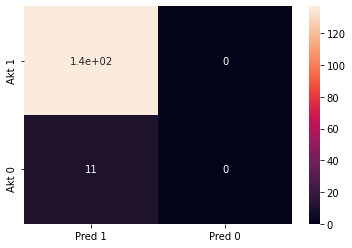

In [144]:
from sklearn.metrics import confusion_matrix, classification_report
y_LRTuned_test = LR_Tuned.predict(X_test)
print(classification_report(y_test, y_LRTuned_test))
cm_LRTuned_test = confusion_matrix(y_test, y_LRTuned_test, labels = [1,0])
df_LRTuned_test = pd.DataFrame(data=cm_LRTuned_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_LRTuned_test, annot=True)
plt.show()

## SMOTE LogReg

In [145]:
sml = SMOTE(random_state=42)

In [146]:
X_train_sml, y_train_sml = sml.fit_sample(X_train, y_train)

In [147]:
df_SMOTELog = pd.concat([X_train_sml, y_train_sml], axis=1)
df_SMOTELog['mAbsence_bin'].value_counts()

1    550
0    550
Name: mAbsence_bin, dtype: int64

In [148]:
LR_Tuned.fit(X_train_sml, y_train_sml)

LogisticRegression(C=0.001)

In [149]:
df_LR_Tuned_SM = Eva_Matrix1(LR_Tuned, X_train_sml, y_train_sml, X_test, y_test, "Model (LR Tuned SM)")
df_LR_Tuned_SM

,Training Model (LR Tuned SM),Test Model (LR Tuned SM)
Accuracy,0.718182,0.641892
Recall,0.632727,0.642336
Precision,0.763158,0.956522
F1,0.691849,0.691849


              precision    recall  f1-score   support

           0       0.12      0.64      0.21        11
           1       0.96      0.64      0.77       137

    accuracy                           0.64       148
   macro avg       0.54      0.64      0.49       148
weighted avg       0.89      0.64      0.73       148



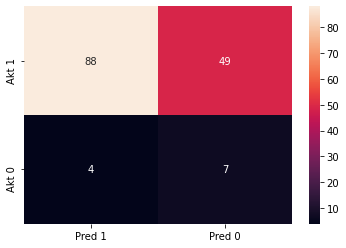

In [150]:
from sklearn.metrics import confusion_matrix, classification_report
y_log_smote_test = LR_Tuned.predict(X_test)
print(classification_report(y_test, y_log_smote_test))
cm_log_smote_test = confusion_matrix(y_test, y_log_smote_test, labels = [1,0])
df_log_smote_test = pd.DataFrame(data=cm_log_smote_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_log_smote_test, annot=True)
plt.show()

## KNNeighbors

In [151]:
param_KNN = {
    'n_neighbors' : np.arange(1,51,10),
    'weights' : ['uniform','distance'],
    'p' : [2, 1]
}

In [152]:
KNN_Tuned = GridSearchCV(Model_KNN, param_KNN, cv = skf, n_jobs = -1, verbose = 1, scoring = 'recall')

In [153]:
KNN_Tuned.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  60 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1, 11, 21, 31, 41]),
                         'p': [2, 1], 'weights': ['uniform', 'distance']},
             scoring='recall', verbose=1)

In [154]:
KNN_Tuned.best_params_

{'n_neighbors': 21, 'p': 2, 'weights': 'uniform'}

In [155]:
KNN_Tuned = KNN_Tuned.best_estimator_

In [156]:
df_KNN_Tuned = Eva_Matrix1(KNN_Tuned, X_train, y_train, X_test, y_test, "Model (KNN Tuned)")
df_KNN_Tuned

,Training Model (KNN Tuned),Test Model (KNN Tuned)
Accuracy,0.929054,0.925676
Recall,1.000000,1.000000
Precision,0.929054,0.925676
F1,0.963222,0.963222


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.93      1.00      0.96       137

    accuracy                           0.93       148
   macro avg       0.46      0.50      0.48       148
weighted avg       0.86      0.93      0.89       148



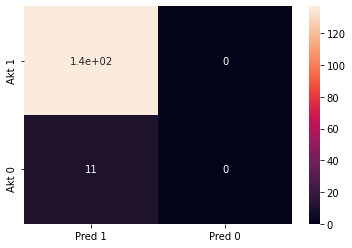

In [157]:
from sklearn.metrics import confusion_matrix, classification_report
y_KNNTuned_test = KNN_Tuned.predict(X_test)
print(classification_report(y_test, y_KNNTuned_test))
cm_KNNTuned_test = confusion_matrix(y_test, y_KNNTuned_test, labels = [1,0])
df_KNNTuned_test = pd.DataFrame(data=cm_KNNTuned_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_KNNTuned_test, annot=True)
plt.show()

## SMOTE KNN

In [158]:
smknn = SMOTE(random_state=42)

In [159]:
X_train_smknn, y_train_smknn = smknn.fit_sample(X_train, y_train)

In [160]:
df_SMOTEKNN = pd.concat([X_train_smknn, y_train_smknn], axis=1)
df_SMOTEKNN['mAbsence_bin'].value_counts()

1    550
0    550
Name: mAbsence_bin, dtype: int64

In [161]:
KNN_Tuned.fit(X_train_smknn, y_train_smknn)

KNeighborsClassifier(n_neighbors=21)

In [162]:
df_KNN_Tuned_SM = Eva_Matrix1(KNN_Tuned, X_train_smknn, y_train_smknn, X_test, y_test, "Model (KNN Tuned SM)")
df_KNN_Tuned_SM

,Training Model (KNN Tuned SM),Test Model (KNN Tuned SM)
Accuracy,0.842727,0.851351
Recall,0.860000,0.868613
Precision,0.831283,0.967480
F1,0.845398,0.845398


              precision    recall  f1-score   support

           0       0.28      0.64      0.39        11
           1       0.97      0.87      0.92       137

    accuracy                           0.85       148
   macro avg       0.62      0.75      0.65       148
weighted avg       0.92      0.85      0.88       148



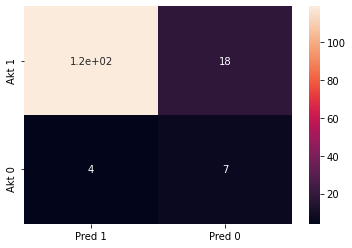

In [163]:
from sklearn.metrics import confusion_matrix, classification_report
y_knn_smote_test = KNN_Tuned.predict(X_test)
print(classification_report(y_test, y_knn_smote_test))
cm_knn_smote_test = confusion_matrix(y_test, y_knn_smote_test, labels = [1,0])
df_knn_smote_test = pd.DataFrame(data=cm_knn_smote_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_knn_smote_test, annot=True)
plt.show()

## SVM

In [164]:
param_SVM = {
    "C" : np.logspace(-3,3,7)
}

In [165]:
SVM_Tuned = GridSearchCV(Model_SVM, param_SVM, cv = skf, n_jobs = -1, verbose = 1, scoring = 'recall')

In [166]:
SVM_Tuned.fit(X_train, y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SVC(max_iter=400), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='recall', verbose=1)

In [167]:
SVM_Tuned.best_params_

{'C': 0.001}

In [168]:
SVM_Tuned = SVM_Tuned.best_estimator_

In [169]:
df_SVM_Tuned = Eva_Matrix1(SVM_Tuned, X_train, y_train, X_test, y_test, "Model (SVM Tuned)")
df_SVM_Tuned

,Training Model (SVM Tuned),Test Model (SVM Tuned)
Accuracy,0.929054,0.925676
Recall,1.000000,1.000000
Precision,0.929054,0.925676
F1,0.963222,0.963222


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.93      1.00      0.96       137

    accuracy                           0.93       148
   macro avg       0.46      0.50      0.48       148
weighted avg       0.86      0.93      0.89       148



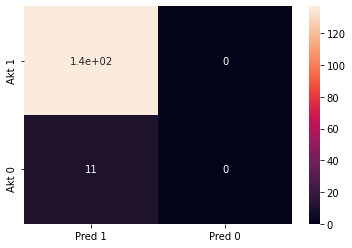

In [170]:
from sklearn.metrics import confusion_matrix, classification_report
y_SVMTuned_test = SVM_Tuned.predict(X_test)
print(classification_report(y_test, y_SVMTuned_test))
cm_SVMTuned_test = confusion_matrix(y_test, y_SVMTuned_test, labels = [1,0])
df_SVMTuned_test = pd.DataFrame(data=cm_SVMTuned_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_SVMTuned_test, annot=True)
plt.show()

## SMOTE SVM

In [171]:
smsvm = SMOTE(random_state=42)

In [172]:
X_train_smsvm, y_train_smsvm = smsvm.fit_sample(X_train, y_train)

In [173]:
df_SMOTESVM = pd.concat([X_train_smsvm, y_train_smsvm], axis=1)
df_SMOTESVM['mAbsence_bin'].value_counts()

1    550
0    550
Name: mAbsence_bin, dtype: int64

In [174]:
SVM_Tuned.fit(X_train_smsvm, y_train_smsvm)

SVC(C=0.001, max_iter=400)

In [175]:
df_SVM_Tuned_SM = Eva_Matrix1(SVM_Tuned, X_train_smsvm, y_train_smsvm, X_test, y_test, "Model (SVM Tuned SM)")
df_SVM_Tuned_SM

,Training Model (SVM Tuned SM),Test Model (SVM Tuned SM)
Accuracy,0.657273,0.601351
Recall,0.581818,0.591241
Precision,0.685225,0.964286
F1,0.629302,0.629302


              precision    recall  f1-score   support

           0       0.28      0.64      0.39        11
           1       0.97      0.87      0.92       137

    accuracy                           0.85       148
   macro avg       0.62      0.75      0.65       148
weighted avg       0.92      0.85      0.88       148



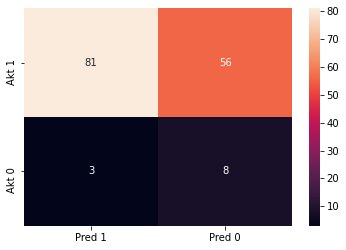

In [176]:
from sklearn.metrics import confusion_matrix, classification_report
y_svm_smote_test = SVM_Tuned.predict(X_test)
print(classification_report(y_test, y_knn_smote_test))
cm_svm_smote_test = confusion_matrix(y_test, y_svm_smote_test, labels = [1,0])
df_svm_smote_test = pd.DataFrame(data=cm_svm_smote_test, columns=['Pred 1', 'Pred 0'], index=['Akt 1', 'Akt 0'])
sns.heatmap(df_svm_smote_test, annot=True)
plt.show()

## Conclusion EDA
- Antara Transportations Expense dan mAbsence_bin 0.245
- Antara Distance from Residence to Work dan mAbsence_bin 0.321
- Antara Service Time dan mAbsence_bin 0.267
- Antara Age dan mAbsence_bin 0.27
- Antara Hit Target dan mAbsence_bin 0.63
- Antara Disciplinary Failure dan mAbsence_bin 0.066
- Antara Education dan mAbsence_bin 0.035
- Antara Jumlah Anak (son) dan mAbsence_bin 0.098
- Antara Social Drinker dan mAbsence_bin 0.128
- Antara Social Smoker dan mAbsence_bin 0.0026
- Antara Jumlah Pet dan mAbsence_bin 0.0838
- Antara Weight dan mAbsence_bin 0.295
- Antara Height dan mAbsence_bin 0.164
- Antara BMI dan mAbsence_bin 0.277
- Insight tidak punya anak lebih banyak absen (mungkin tidak ada relasi, karena bisa saja memang banyak orang tidak memiliki anak)
- Insight umur muda lebih banyak absen
- Insight lebih banyak absen dengan alasan Medical Consultation
- Insight Education rendah lebih banyak absen
- Insight tidak punya pet lebih banyak absen (mungkin tidak ada relasi, karena bisa saja memang banyak orang tidak memiliki pet)
- Insight banyak yg berat badan tinggi yg absen

## Recommendation EDA
- Banyak yang absen karena ingin melakukan medical consultation dan hal ini bisa saja dicegah jika kantor mulai untuk melihat kesehatan karyawannya
- Anyak dari mereka juga memiliki pendidikan yang lebih rendah, hal ini mungkin karena banyak terjadi dimana senior lebih banyak memberikan tugas kepada bawahannya yang mengakibatkan mereka overwork dan memilih untuk izin

## Conclusion ML

## Decision Tree yang sudah di Tuning dan SMOTE menjadi model terbaik
     	     
- Accuracy Training Model (DT Tuned SM): 0.910909	                   
- Recall Training Model (DT Tuned SM): 0.947273	                   
- Precision Training Model (DT Tuned SM): 0.883051	                   
- F1 Training Model (DT Tuned SM): 0.914035	                   

- Accuracy Test Model (DT Tuned SM): 0.912162
- Recall Test Model (DT Tuned SM): 0.927007
- Precision Test Model (DT Tuned SM): 0.976923
- F1 Training Test Model (DT Tuned SM): 0.914035

### Aktual Absen, Prediksi Absen: 130
### Aktual Tidak Absen, Prediksi Absen: 3
### Aktual Tidak Absen, Prediksi Tidak Absen: 8
### Aktual Absen, Prediksi Tidak Absen: 10

### Memiliki jumlah FN yg rendah yaitu 10

## Recommendation ML
- Alasan mengambil Model ini adalah karena meiliki FN atau Recall yang bagus
- Alasan memprioritaskan FN atau Recall adalah karena kita ingin meminimalisir prediksi Tidak Absen sedangkan Aktual Absen
- Seperti Contoh di model ini memiliki FN hanya 10 yang artinya mesin hanya salah 10 orang saja yang dikira Tidak Absen dan Ternyata Absen

## Export Keluar Model DT

In [177]:
# joblib.dump(DT_Tuned, 'Model Absenteeism DT.jbl')